In [1]:
try :
  from google.colab import drive
  IN_COLAB = True
except:
  IN_COLAB = False
print('IN COLAB: ', IN_COLAB)

IN COLAB:  True


In [2]:
import os
import pandas as pd

parentdir = "./propaganda_dataset_v2"
train_file= "propaganda_train.tsv"
val_file= "propaganda_val.tsv"

train_path=os.path.join(parentdir,train_file)
val_path=os.path.join(parentdir,val_file)

if IN_COLAB:
  train_path = '/content/propaganda_train.tsv'
  val_path = '/content/propaganda_val.tsv'

train_df=pd.read_csv(train_path,delimiter="\t",quotechar='|')
val_df=pd.read_csv(val_path,delimiter="\t",quotechar='|')


In [3]:
def transform_binaryify(row):
    new_value = 0 if row['label'] == 'not_propaganda' else 1
    return new_value

def transform_strip_tag(row):
    sent = row['tagged_in_context']
    cleaned_string = sent.replace("<BOS>", "")
    cleaned_string = cleaned_string.replace("<EOS>", "")
    return cleaned_string


train_df['propaganda'] = train_df.apply(transform_binaryify, axis=1)
train_df['original_without_snip_tags'] = train_df.apply(transform_strip_tag, axis=1)


val_df['propaganda'] = val_df.apply(transform_binaryify, axis=1)
val_df['original_without_snip_tags'] = val_df.apply(transform_strip_tag, axis=1)

train_df
val_df

,label,tagged_in_context,propaganda,original_without_snip_tags
0,not_propaganda,"On average, between 300 and 600 infections are...",0,"On average, between 300 and 600 infections are..."
1,causal_oversimplification,Mostly because <BOS> the country would not las...,1,Mostly because the country would not last lon...
2,appeal_to_fear_prejudice,Lyndon Johnson <BOS> gets Earl Warren and Sen....,1,Lyndon Johnson gets Earl Warren and Sen. Rich...
3,not_propaganda,<BOS> You <EOS> may opt out at anytime.,0,You may opt out at anytime.
4,repetition,It must be exacted from him directly in order ...,1,It must be exacted from him directly in order ...
...,...,...,...,...
635,not_propaganda,"NewsCatholic Church, <BOS> Family, Marriage <E...",0,"NewsCatholic Church, Family, Marriage"
636,not_propaganda,"Remember our saying, modern day fairy <BOS> ta...",0,"Remember our saying, modern day fairy tales s..."
637,not_propaganda,Why <BOS> not <EOS> open up to Iran with massi...,0,Why not open up to Iran with massive amounts...
638,flag_waving,<BOS> He also sang an Islamic State fight song...,1,He also sang an Islamic State fight song and ...


In [4]:
# wills
epochs = 60
lr = 5e-6
batch_size=80
max_len=150
n_classes = 2

In [5]:
from torch.utils.data import DataLoader, Dataset
from transformers import BertModel, BertTokenizer
import torch
import numpy as np


class CustomPropagandaDataset_vanilla(Dataset):
    def __init__(self,df, max_len):
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

        self.labels=torch.tensor([label for label in df['propaganda']])
        self.texts=[tokenizer(text,padding='max_length',max_length=max_len,truncation=True,return_tensors="pt") for text in df['original_without_snip_tags']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self,idx):
        return np.array(self.labels[idx])

    def get_batch_texts(self,idx):
        return self.texts[idx]

    def __getitem__(self,idx):
        batch_texts=self.get_batch_texts(idx)
        batch_y=self.get_batch_labels(idx)

        return batch_texts,batch_y


def prepare_inputs(input1,label,device):
  label=label.to(device)
  mask=input1['attention_mask'].to(device)
  input_id=input1['input_ids'].squeeze(1).to(device)
  return (input_id,mask,label)

In [6]:
train_data = CustomPropagandaDataset_vanilla(train_df, max_len)
val_data = CustomPropagandaDataset_vanilla(val_df, max_len)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
train_dataloader=torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True)
val_dataloader=torch.utils.data.DataLoader(val_data,batch_size=batch_size)

In [8]:
from torch import nn

class BertClassifier(nn.Module):

    def __init__(self,dropout=0.5,num_classes=2):
        super(BertClassifier, self).__init__()

        self.bert=BertModel.from_pretrained('bert-base-uncased')
        self.dropout=nn.Dropout(dropout)
        self.linear=nn.Linear(768,num_classes)
        self.relu=nn.ReLU()

    def forward(self,input_id,mask):

        _, pooled_output = self.bert(input_ids=input_id,attention_mask=mask,return_dict=False)
        dropout_output=self.dropout(pooled_output)
        linear_output=self.linear(dropout_output)
        final_layer=self.relu(linear_output)

        return final_layer

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


LR: 5e-07


100%|██████████| 32/32 [00:54<00:00,  1.69s/it]


Epochs: 1 | Train Loss: 0.009 | Train Accuracy: 0.516
Val loss: 0.009 | Val Accuracy: 0.497


100%|██████████| 32/32 [00:55<00:00,  1.74s/it]


Epochs: 2 | Train Loss: 0.009 | Train Accuracy: 0.514
Val loss: 0.009 | Val Accuracy: 0.505


100%|██████████| 32/32 [00:57<00:00,  1.79s/it]


Epochs: 3 | Train Loss: 0.009 | Train Accuracy: 0.536
Val loss: 0.009 | Val Accuracy: 0.514


100%|██████████| 32/32 [00:58<00:00,  1.83s/it]


Epochs: 4 | Train Loss: 0.009 | Train Accuracy: 0.537
Val loss: 0.009 | Val Accuracy: 0.523


100%|██████████| 32/32 [00:58<00:00,  1.84s/it]


Epochs: 5 | Train Loss: 0.009 | Train Accuracy: 0.554
Val loss: 0.008 | Val Accuracy: 0.534


100%|██████████| 32/32 [00:58<00:00,  1.84s/it]


Epochs: 6 | Train Loss: 0.009 | Train Accuracy: 0.553
Val loss: 0.008 | Val Accuracy: 0.547


100%|██████████| 32/32 [00:59<00:00,  1.84s/it]


Epochs: 7 | Train Loss: 0.008 | Train Accuracy: 0.566
Val loss: 0.008 | Val Accuracy: 0.575


100%|██████████| 32/32 [00:58<00:00,  1.84s/it]


Epochs: 8 | Train Loss: 0.008 | Train Accuracy: 0.595
Val loss: 0.008 | Val Accuracy: 0.591


100%|██████████| 32/32 [00:59<00:00,  1.84s/it]


Epochs: 9 | Train Loss: 0.008 | Train Accuracy: 0.581
Val loss: 0.008 | Val Accuracy: 0.605


100%|██████████| 32/32 [00:58<00:00,  1.84s/it]


Epochs: 10 | Train Loss: 0.008 | Train Accuracy: 0.618
Val loss: 0.008 | Val Accuracy: 0.613


100%|██████████| 32/32 [00:58<00:00,  1.84s/it]


Epochs: 11 | Train Loss: 0.008 | Train Accuracy: 0.622
Val loss: 0.008 | Val Accuracy: 0.627


100%|██████████| 32/32 [00:58<00:00,  1.84s/it]


Epochs: 12 | Train Loss: 0.008 | Train Accuracy: 0.632
Val loss: 0.008 | Val Accuracy: 0.633


100%|██████████| 32/32 [00:58<00:00,  1.84s/it]


Epochs: 13 | Train Loss: 0.008 | Train Accuracy: 0.643
Val loss: 0.008 | Val Accuracy: 0.639


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 14 | Train Loss: 0.008 | Train Accuracy: 0.662
Val loss: 0.008 | Val Accuracy: 0.642


100%|██████████| 32/32 [00:59<00:00,  1.84s/it]


Epochs: 15 | Train Loss: 0.008 | Train Accuracy: 0.664
Val loss: 0.008 | Val Accuracy: 0.658


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 16 | Train Loss: 0.008 | Train Accuracy: 0.682
Val loss: 0.008 | Val Accuracy: 0.645


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 17 | Train Loss: 0.008 | Train Accuracy: 0.677
Val loss: 0.008 | Val Accuracy: 0.670


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 18 | Train Loss: 0.008 | Train Accuracy: 0.698
Val loss: 0.008 | Val Accuracy: 0.670


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 19 | Train Loss: 0.008 | Train Accuracy: 0.697
Val loss: 0.008 | Val Accuracy: 0.684


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 20 | Train Loss: 0.007 | Train Accuracy: 0.725
Val loss: 0.008 | Val Accuracy: 0.698


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 21 | Train Loss: 0.007 | Train Accuracy: 0.723
Val loss: 0.007 | Val Accuracy: 0.688


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 22 | Train Loss: 0.007 | Train Accuracy: 0.724
Val loss: 0.007 | Val Accuracy: 0.698


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 23 | Train Loss: 0.007 | Train Accuracy: 0.743
Val loss: 0.007 | Val Accuracy: 0.697


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 24 | Train Loss: 0.007 | Train Accuracy: 0.735
Val loss: 0.007 | Val Accuracy: 0.703


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 25 | Train Loss: 0.007 | Train Accuracy: 0.743
Val loss: 0.007 | Val Accuracy: 0.703


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 26 | Train Loss: 0.007 | Train Accuracy: 0.756
Val loss: 0.007 | Val Accuracy: 0.713


100%|██████████| 32/32 [00:59<00:00,  1.84s/it]


Epochs: 27 | Train Loss: 0.007 | Train Accuracy: 0.770
Val loss: 0.007 | Val Accuracy: 0.713


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 28 | Train Loss: 0.007 | Train Accuracy: 0.774
Val loss: 0.007 | Val Accuracy: 0.728


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 29 | Train Loss: 0.007 | Train Accuracy: 0.771
Val loss: 0.007 | Val Accuracy: 0.716


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 30 | Train Loss: 0.007 | Train Accuracy: 0.775
Val loss: 0.007 | Val Accuracy: 0.727


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 31 | Train Loss: 0.007 | Train Accuracy: 0.782
Val loss: 0.007 | Val Accuracy: 0.722


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 32 | Train Loss: 0.007 | Train Accuracy: 0.787
Val loss: 0.007 | Val Accuracy: 0.727


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 33 | Train Loss: 0.006 | Train Accuracy: 0.786
Val loss: 0.007 | Val Accuracy: 0.738


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 34 | Train Loss: 0.006 | Train Accuracy: 0.798
Val loss: 0.007 | Val Accuracy: 0.738


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 35 | Train Loss: 0.006 | Train Accuracy: 0.800
Val loss: 0.007 | Val Accuracy: 0.731


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 36 | Train Loss: 0.006 | Train Accuracy: 0.795
Val loss: 0.007 | Val Accuracy: 0.745


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 37 | Train Loss: 0.006 | Train Accuracy: 0.802
Val loss: 0.007 | Val Accuracy: 0.742


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 38 | Train Loss: 0.006 | Train Accuracy: 0.807
Val loss: 0.007 | Val Accuracy: 0.736


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 39 | Train Loss: 0.006 | Train Accuracy: 0.816
Val loss: 0.007 | Val Accuracy: 0.739


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 40 | Train Loss: 0.006 | Train Accuracy: 0.816
Val loss: 0.007 | Val Accuracy: 0.742


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 41 | Train Loss: 0.006 | Train Accuracy: 0.822
Val loss: 0.007 | Val Accuracy: 0.742


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 42 | Train Loss: 0.006 | Train Accuracy: 0.820
Val loss: 0.007 | Val Accuracy: 0.750


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 43 | Train Loss: 0.006 | Train Accuracy: 0.823
Val loss: 0.007 | Val Accuracy: 0.755


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 44 | Train Loss: 0.006 | Train Accuracy: 0.825
Val loss: 0.007 | Val Accuracy: 0.753


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 45 | Train Loss: 0.006 | Train Accuracy: 0.830
Val loss: 0.007 | Val Accuracy: 0.747


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 46 | Train Loss: 0.006 | Train Accuracy: 0.829
Val loss: 0.007 | Val Accuracy: 0.750


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 47 | Train Loss: 0.005 | Train Accuracy: 0.831
Val loss: 0.007 | Val Accuracy: 0.758


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 48 | Train Loss: 0.005 | Train Accuracy: 0.838
Val loss: 0.007 | Val Accuracy: 0.750


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 49 | Train Loss: 0.005 | Train Accuracy: 0.845
Val loss: 0.006 | Val Accuracy: 0.762


100%|██████████| 32/32 [00:59<00:00,  1.86s/it]


Epochs: 50 | Train Loss: 0.005 | Train Accuracy: 0.840
Val loss: 0.006 | Val Accuracy: 0.759


100%|██████████| 32/32 [00:59<00:00,  1.86s/it]


Epochs: 51 | Train Loss: 0.005 | Train Accuracy: 0.844
Val loss: 0.006 | Val Accuracy: 0.761


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 52 | Train Loss: 0.005 | Train Accuracy: 0.842
Val loss: 0.006 | Val Accuracy: 0.759


100%|██████████| 32/32 [00:59<00:00,  1.86s/it]


Epochs: 53 | Train Loss: 0.005 | Train Accuracy: 0.850
Val loss: 0.006 | Val Accuracy: 0.767


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 54 | Train Loss: 0.005 | Train Accuracy: 0.853
Val loss: 0.006 | Val Accuracy: 0.766


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 55 | Train Loss: 0.005 | Train Accuracy: 0.852
Val loss: 0.006 | Val Accuracy: 0.764


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 56 | Train Loss: 0.005 | Train Accuracy: 0.852
Val loss: 0.006 | Val Accuracy: 0.769


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 57 | Train Loss: 0.005 | Train Accuracy: 0.856
Val loss: 0.006 | Val Accuracy: 0.758


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 58 | Train Loss: 0.005 | Train Accuracy: 0.852
Val loss: 0.006 | Val Accuracy: 0.773


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 59 | Train Loss: 0.005 | Train Accuracy: 0.870
Val loss: 0.006 | Val Accuracy: 0.772


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


Epochs: 60 | Train Loss: 0.005 | Train Accuracy: 0.864
Val loss: 0.006 | Val Accuracy: 0.766
______354aca28-406f-41da-8465-69b55d6dcd8b______
LR: 5e-07 FINAL ACC = 0.766
LR: 5e-07 BEST ACC = 0.773
____________


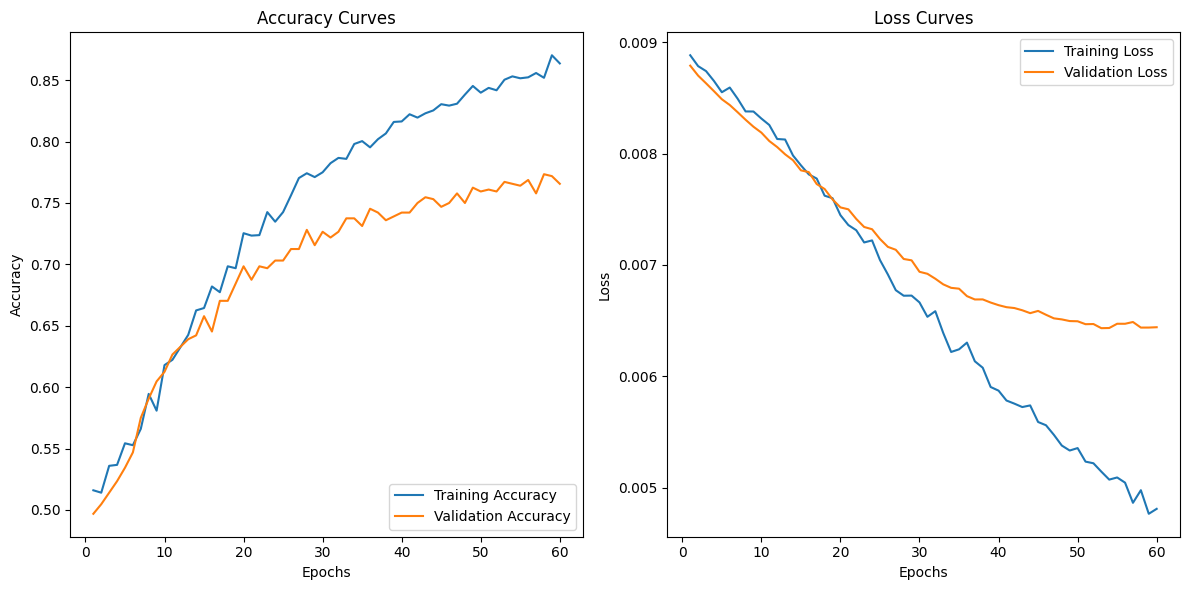

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.77      0.78      0.77       331
     Class 1       0.76      0.75      0.76       309

    accuracy                           0.77       640
   macro avg       0.77      0.77      0.77       640
weighted avg       0.77      0.77      0.77       640



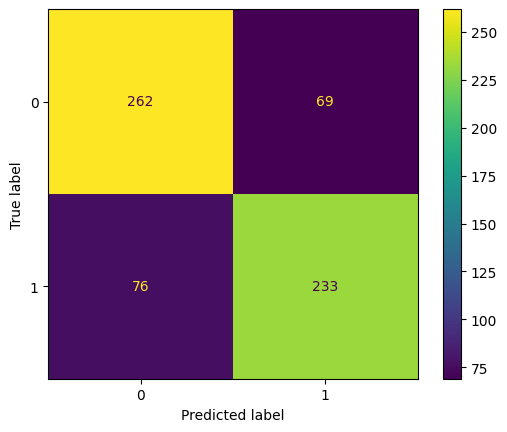

In [9]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import json
import uuid

# just these two ray
lrs = [5e-7]
# lrs = [5e-5, 1e-5, 5e-6, 1e-6]

for lr in lrs:
  print('LR:', lr)
  model=BertClassifier(num_classes=n_classes).to(device)
  criterion=nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)


  train_acc_list = []
  train_loss_list = []
  val_acc_list = []
  val_loss_list = []

  best_val_acc = 0
  best_epoch = 0
  best_model_state = None

  model_id = str(uuid.uuid4())


  for epoch_num in range(epochs):


          total_acc_train=0
          total_loss_train=0
          model.train()

          for train_input,train_label in tqdm(train_dataloader):

              input_id,mask, train_label=prepare_inputs(train_input,train_label,device)

              output_1=model(input_id,mask)

              batch_loss_1=criterion(output_1,train_label.long())

              total_loss_train += batch_loss_1.item()

              acc=(output_1.argmax(dim=1)==train_label).sum().item()
              total_acc_train+=acc

              model.zero_grad()
              batch_loss_1.backward()
              optimizer.step()

          total_acc_val=0
          total_loss_val=0

          y_true = []
          y_pred = []
          model.eval()
          with torch.no_grad():
              for val_input,val_label in val_dataloader:

                  input_id,mask, val_label=prepare_inputs(val_input,val_label,device)

                  output_2= model(input_id,mask)

                  # for scoring
                  predicted = output_2.argmax(dim=1)
                  y_true.extend(val_label.cpu().numpy())
                  y_pred.extend(predicted.cpu().numpy())

                  batch_loss_2=criterion(output_2,val_label.long())

                  total_loss_val+=batch_loss_2.item()

                  acc=(output_2.argmax(dim=1)==val_label).sum().item()
                  total_acc_val+=acc
          
          train_acc = total_acc_train / len(train_data)
          train_loss = total_loss_train / len(train_data)
          val_acc = total_acc_val / len(val_data)
          val_loss = total_loss_val / len(val_data)

          train_acc_list.append(train_acc)
          train_loss_list.append(train_loss)
          val_acc_list.append(val_acc)
          val_loss_list.append(val_loss)

          print(f'Epochs: {epoch_num+1} | Train Loss: {total_loss_train / len(train_data):.3f} | Train Accuracy: {total_acc_train/len(train_data):.3f}')
          print(f'Val loss: {total_loss_val/len(val_data):.3f} | Val Accuracy: {total_acc_val / len(val_data):.3f}')
          if val_acc > best_val_acc:
            best_epoch = epoch_num
            y_true_best = y_true.copy()
            y_pred_best = y_pred.copy()
            best_val_acc = val_acc
            best_model_state = model.state_dict()

          if epoch_num == epochs-1:
              print(f'______{model_id}______')
              print(f'LR: {lr} FINAL ACC = {total_acc_val / len(val_data):.3f}')
              print(f'LR: {lr} BEST ACC = {best_val_acc:.3f}')
              print('____________')

  # Plot the accuracy and loss curves over epochs
  epochs_range = range(1, epochs+1)

  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, train_acc_list, label='Training Accuracy')
  plt.plot(epochs_range, val_acc_list, label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.title('Accuracy Curves')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, train_loss_list, label='Training Loss')
  plt.plot(epochs_range, val_loss_list, label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(loc='upper right')
  plt.title('Loss Curves')

  plt.tight_layout()
  plt.show()
  # analysis of best performing model

  cm = confusion_matrix(y_true_best, y_pred_best)
  disp = ConfusionMatrixDisplay(cm)
  disp.plot()
  classes = ['Class 0', 'Class 1']  # Replace with your class labels

  # Compute precision, recall, F1-score, and other metrics for best one
  report = classification_report(y_true, y_pred, target_names=classes)
  print('Classification Report:')
  print(report)
  results_dict = {
    'model_id': model_id,
    'train_accuracy': train_acc_list,
    'train_loss': train_loss_list,
    'val_accuracy': val_acc_list,
    'val_loss': val_loss_list,
    'hyperparameters': {
        'learning_rate': lr,
        'num_epochs': epochs,
        'batch_size': batch_size,
        'max_len': max_len
    },
    'results': {
        "classes": n_classes,
        "last_acc": val_acc_list[-1],
        'best_acc': best_val_acc,
        'best_acc_epoch': best_epoch,
        'confusion_matrix': cm.tolist(),
        'classification_report': report
    }
}

  # Save the results dictionary as a JSON file with the model ID
  results_filename = f'./results/binary_results_{model_id}.json'
  with open(results_filename, 'w') as f:
      json.dump(results_dict, f, indent=4)

  # Save the best model state with the model ID
  model_filename = f'./results/binary_best_model_{model_id}.pth'
  torch.save(best_model_state, model_filename)


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.77      0.78      0.77       331
     Class 1       0.76      0.75      0.76       309

    accuracy                           0.77       640
   macro avg       0.77      0.77      0.77       640
weighted avg       0.77      0.77      0.77       640



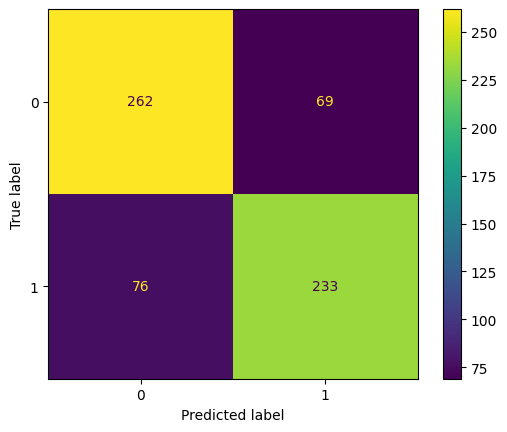

In [10]:
# analysis of best performing model

cm = confusion_matrix(y_true_best, y_pred_best)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
classes = ['Class 0', 'Class 1']  # Replace with your class labels

# Compute precision, recall, F1-score, and other metrics for best one
report = classification_report(y_true, y_pred, target_names=classes)
print('Classification Report:')
print(report)


In [11]:
results_dict = {
    'model_id': model_id,
    'train_accuracy': train_acc_list,
    'train_loss': train_loss_list,
    'val_accuracy': val_acc_list,
    'val_loss': val_loss_list,
    'hyperparameters': {
        'learning_rate': lr,
        'num_epochs': epochs,
        'batch_size': batch_size,
        'max_len': max_len
    },
    'results': {
        "classes": n_classes,
        "last_acc": val_acc_list[-1],
        'best_acc': best_val_acc,
        'best_acc_epoch': best_epoch,
        'confusion_matrix': cm.tolist(),
        'classification_report': report
    }
}

# Save the results dictionary as a JSON file with the model ID
results_filename = f'./results/binary_results_{model_id}.json'
with open(results_filename, 'w') as f:
    json.dump(results_dict, f, indent=4)

# Save the best model state with the model ID
model_filename = f'./results/binary_best_model_{model_id}.pth'
torch.save(best_model_state, model_filename)